# Code for Implementing a Global NeuralProphet Model

***

## Step 1: Import Modules and Data

In [1]:
# general modules
import pandas as pd
import numpy as np

# import NeuralProphet model, functions to set log level and random seed
from neuralprophet import NeuralProphet, set_log_level
from neuralprophet import set_random_seed
from neuralprophet.df_utils import split_df

# import mean absolute error and mean squared error metrics (specify square root in function)
from sktime.performance_metrics.forecasting import mean_absolute_error, mean_squared_error

# nice time series plots
from sktime.utils.plotting import plot_series

# set random seed and log level
set_random_seed(10)
set_log_level("ERROR", "INFO")

In [2]:
# import weekly finance time series
Y = pd.read_csv("../../../Data/Train/Clean/weekly_finance_clean.csv")

# import M4 info and store the starting data of each series
m4_info = pd.read_csv("../../../Data/M4-info.csv")
start_dates = m4_info.loc[(m4_info.SP == "Weekly") & (m4_info.category == "Finance"), "StartingDate"]

In [3]:
# store the number of series and number of time periods
num_series, num_periods = Y.shape

In [4]:
# calculate mean of each series
series_means = Y.mean(axis=1)

In [5]:
# normalize each series by the mean and log-transform
Y_t = np.log(Y.divide(series_means, axis=0))

In [6]:
# store DateTime index for first series
y_index = pd.date_range(start=start_dates.iloc[0], periods=num_periods, freq="W")

We're going to start by converting each series (row) in `Y_t` into a dataframe as needed for `neural_prophet`. The dataframes for each series will be stored together in a dictionary.

In [7]:
# dictionary to store dataframes
df_dict = {}

for i in range(num_series):
    # copy series i
    y = Y_t.iloc[i,:].copy()
    
    # set series index to DateTime of first series (using as common index for now)
    y.index = y_index
    
    # convert to dataframe and rename columns appropriately
    y = y.reset_index().rename(columns={'index':'ds', i:'y'})
    
    # store new dataframe in list and dictionary
    df_dict[i] = y

***

## Train Model

In [8]:
# forecast horizon
h = 20
# whether to perform internal normalization
normalize = "off"
# how many lags to use in auto-regression
n_lags = 20
# how many hidden layers in AR-NET - default is zero
num_hidden_layers = 1 
# dimension of hidden layers - default is zero when num_hidden_layers = 0
d_hidden = 50

# define forecasting model
m = NeuralProphet(normalize=normalize,
                  n_lags=n_lags,
                  n_forecasts=h,
                  num_hidden_layers=num_hidden_layers,
                  d_hidden=d_hidden)

In [9]:
# create dictionaries of train and test data
# specify weekly frequency, use last 20 rows as test data, and split in local dataframes
train_dict, test_dict = split_df(df=df_dict,
                                 n_lags=1,
                                 n_forecasts=1,
                                 valid_p=h-1,
                                 local_split=True,
                                 inputs_overbleed=False)

In [10]:
train_dict[0]

,ds,y
0,1973-03-04 12:00:00,0.045797
1,1973-03-11 12:00:00,0.046269
2,1973-03-18 12:00:00,0.046333
3,1973-03-25 12:00:00,0.045894
4,1973-04-01 12:00:00,0.041818
...,...,...
222,1977-06-05 12:00:00,0.035406
223,1977-06-12 12:00:00,0.032377
224,1977-06-19 12:00:00,0.032848
225,1977-06-26 12:00:00,0.034537


In [11]:
test_dict[0]

,ds,y
0,1977-07-10 12:00:00,0.033168
1,1977-07-17 12:00:00,0.034047
2,1977-07-24 12:00:00,0.033913
3,1977-07-31 12:00:00,0.033877
4,1977-08-07 12:00:00,0.033656
5,1977-08-14 12:00:00,0.031464
6,1977-08-21 12:00:00,0.032170
7,1977-08-28 12:00:00,0.030887
8,1977-09-04 12:00:00,0.023592
9,1977-09-11 12:00:00,0.020972


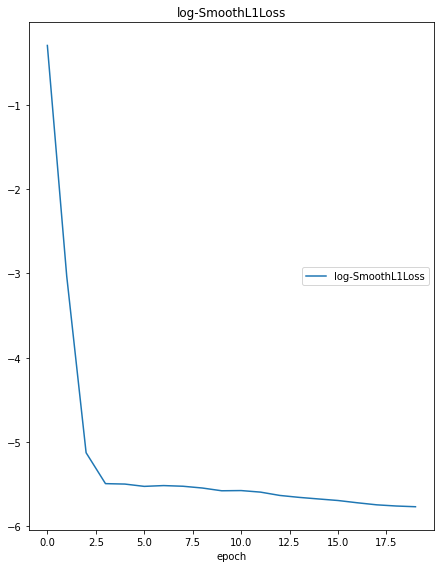

log-SmoothL1Loss
	log-SmoothL1Loss 	 (min:   -5.768, max:   -0.294, cur:   -5.768)


In [12]:
# fit the model on the training data
# plot training progress
metrics = m.fit(train_dict, freq="W", progress="plot")

In [13]:
# dataframe to store predictions
future = m.make_future_dataframe(train_dict, n_historic_predictions=True)

In [14]:
future[0].iloc[224:,:]

,ds,y
224,1977-06-19 12:00:00,0.032848
225,1977-06-26 12:00:00,0.034537
226,1977-07-03 12:00:00,0.032695
227,1977-07-10 12:00:00,NaN
228,1977-07-17 12:00:00,NaN
229,1977-07-24 12:00:00,NaN
230,1977-07-31 12:00:00,NaN
231,1977-08-07 12:00:00,NaN
232,1977-08-14 12:00:00,NaN
233,1977-08-21 12:00:00,NaN


In [15]:
# generate forecasts
forecast = m.predict(future)

In [16]:
forecast[0]

,ds,y,yhat1,residual1,yhat2,residual2,yhat3,residual3,yhat4,residual4,...,ar13,ar14,ar15,ar16,ar17,ar18,ar19,ar20,trend,season_yearly
0,1973-03-04 12:00:00,0.045797,None,NaN,None,NaN,None,NaN,None,NaN,...,None,None,None,None,None,None,None,None,None,None
1,1973-03-11 12:00:00,0.046269,None,NaN,None,NaN,None,NaN,None,NaN,...,None,None,None,None,None,None,None,None,None,None
2,1973-03-18 12:00:00,0.046333,None,NaN,None,NaN,None,NaN,None,NaN,...,None,None,None,None,None,None,None,None,None,None
3,1973-03-25 12:00:00,0.045894,None,NaN,None,NaN,None,NaN,None,NaN,...,None,None,None,None,None,None,None,None,None,None
4,1973-04-01 12:00:00,0.041818,None,NaN,None,NaN,None,NaN,None,NaN,...,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
242,1977-10-23 12:00:00,NaN,None,NaN,None,NaN,None,NaN,None,NaN,...,None,None,None,0.525353,0.524424,0.522112,0.523474,0.525458,-0.484591,-0.003397
243,1977-10-30 12:00:00,NaN,None,NaN,None,NaN,None,NaN,None,NaN,...,None,None,None,None,0.524494,0.524004,0.524042,0.524031,-0.484505,-0.003184
244,1977-11-06 12:00:00,NaN,None,NaN,None,NaN,None,NaN,None,NaN,...,None,None,None,None,None,0.523903,0.525183,0.524507,-0.484418,-0.00304
245,1977-11-13 12:00:00,NaN,None,NaN,None,NaN,None,NaN,None,NaN,...,None,None,None,None,None,None,0.5251,0.525901,-0.484332,-0.003011


In [17]:
forecast[0].filter(regex='y')

,y,yhat1,yhat2,yhat3,yhat4,yhat5,yhat6,yhat7,yhat8,yhat9,...,yhat12,yhat13,yhat14,yhat15,yhat16,yhat17,yhat18,yhat19,yhat20,season_yearly
0,0.045797,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
1,0.046269,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
2,0.046333,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
3,0.045894,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
4,0.041818,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
242,NaN,None,None,None,None,None,None,None,None,None,...,None,None,None,None,0.037365,0.036437,0.034124,0.035487,0.03747,-0.003397
243,NaN,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,0.036805,0.036316,0.036353,0.036342,-0.003184
244,NaN,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,0.036445,0.037724,0.037048,-0.00304
245,NaN,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,0.037757,0.038558,-0.003011


In [18]:
forecast[0].filter(regex='yhat').iloc[224:,:]

,yhat1,yhat2,yhat3,yhat4,yhat5,yhat6,yhat7,yhat8,yhat9,yhat10,yhat11,yhat12,yhat13,yhat14,yhat15,yhat16,yhat17,yhat18,yhat19,yhat20
224,0.03417,0.036579,0.037719,0.038353,0.039535,0.037844,0.038865,0.038258,0.038972,0.041777,0.041655,0.039368,0.038442,0.036296,0.035286,0.040657,0.043416,0.045531,0.046748,0.041728
225,0.032872,0.033964,0.035155,0.035288,0.0394,0.039284,0.038305,0.037162,0.038512,0.039978,0.041275,0.038871,0.038881,0.038284,0.034555,0.036229,0.039244,0.041968,0.045358,0.045854
226,0.034438,0.034022,0.034552,0.036328,0.038514,0.040016,0.041203,0.039183,0.039973,0.040697,0.04064,0.040356,0.04022,0.040272,0.037959,0.037295,0.037009,0.040247,0.04359,0.046599
227,0.033504,0.034921,0.034413,0.033312,0.036291,0.038293,0.041016,0.040736,0.039477,0.040826,0.03999,0.038364,0.039841,0.040596,0.038439,0.039795,0.037001,0.035774,0.03958,0.043938
228,None,0.034629,0.035577,0.032978,0.034136,0.037228,0.037258,0.039527,0.041046,0.039918,0.039393,0.037401,0.038676,0.040762,0.040274,0.040291,0.038494,0.036047,0.03631,0.040396
229,None,None,0.035013,0.033786,0.033781,0.03478,0.034535,0.036992,0.040902,0.041773,0.039184,0.037659,0.039011,0.039123,0.040484,0.040857,0.039682,0.037854,0.037225,0.037523
230,None,None,None,0.03343,0.035318,0.035171,0.035197,0.038494,0.040567,0.043536,0.043334,0.041072,0.040782,0.041169,0.040972,0.044056,0.04359,0.041269,0.042168,0.039753
231,None,None,None,None,0.034516,0.035449,0.03575,0.035256,0.038294,0.041928,0.043466,0.042262,0.040173,0.041181,0.039923,0.042372,0.043384,0.042132,0.041922,0.041622
232,None,None,None,None,None,0.034276,0.036418,0.034811,0.034851,0.038942,0.040035,0.040777,0.040266,0.039435,0.038422,0.039684,0.040698,0.041688,0.041894,0.041581
233,None,None,None,None,None,None,0.035316,0.034838,0.033723,0.035052,0.036271,0.036957,0.038449,0.040111,0.03683,0.038761,0.039122,0.03962,0.041913,0.041313


In [19]:
n_train_periods = num_periods - h

In [20]:
forecast[0].filter(regex='yhat').iloc[n_train_periods,:]

yhat1     0.033504
yhat2     0.034921
yhat3     0.034413
yhat4     0.033312
yhat5     0.036291
yhat6     0.038293
yhat7     0.041016
yhat8     0.040736
yhat9     0.039477
yhat10    0.040826
yhat11     0.03999
yhat12    0.038364
yhat13    0.039841
yhat14    0.040596
yhat15    0.038439
yhat16    0.039795
yhat17    0.037001
yhat18    0.035774
yhat19     0.03958
yhat20    0.043938
Name: 227, dtype: object

In [21]:
forecast[0].filter(regex='yhat').iloc[n_train_periods,:].astype('float64')

yhat1     0.033504
yhat2     0.034921
yhat3     0.034413
yhat4     0.033312
yhat5     0.036291
yhat6     0.038293
yhat7     0.041016
yhat8     0.040736
yhat9     0.039477
yhat10    0.040826
yhat11    0.039990
yhat12    0.038364
yhat13    0.039841
yhat14    0.040596
yhat15    0.038439
yhat16    0.039795
yhat17    0.037001
yhat18    0.035774
yhat19    0.039580
yhat20    0.043938
Name: 227, dtype: float64

In [22]:
fcasts = forecast[0].filter(regex='yhat').iloc[n_train_periods,:].astype('float64')

In [23]:
test_1 = test_dict[0].assign(yhat=fcasts.values)

In [24]:
test_1

,ds,y,yhat
0,1977-07-10 12:00:00,0.033168,0.033504
1,1977-07-17 12:00:00,0.034047,0.034921
2,1977-07-24 12:00:00,0.033913,0.034413
3,1977-07-31 12:00:00,0.033877,0.033312
4,1977-08-07 12:00:00,0.033656,0.036291
5,1977-08-14 12:00:00,0.031464,0.038293
6,1977-08-21 12:00:00,0.032170,0.041016
7,1977-08-28 12:00:00,0.030887,0.040736
8,1977-09-04 12:00:00,0.023592,0.039477
9,1977-09-11 12:00:00,0.020972,0.040826


(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='y'>)

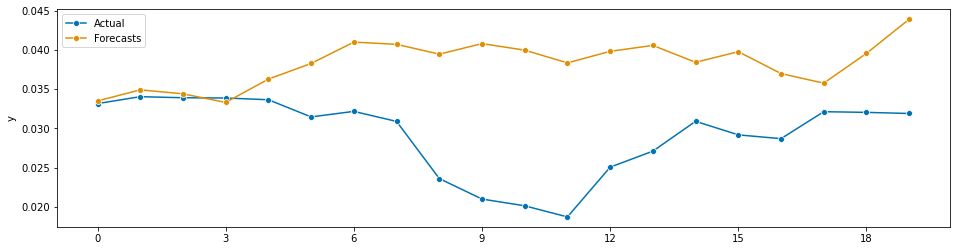

In [25]:
plot_series(test_1.y, test_1.yhat, labels=["Actual", "Forecasts"])

***
***

Now perform the above for all series.

In [26]:
# dictionary to hold forecasts and actual values for each series
fcasts = {}

In [27]:
for i in range(num_series):
    f = forecast[i].filter(regex='yhat').iloc[n_train_periods,:].astype('float64')
    fcasts[i] = test_dict[i].assign(yhat=f.values)
    
    # import mean absolute error and mean squared error metrics (specify square root in function)
from sktime.performance_metrics.forecasting import mean_absolute_error, mean_squared_error

In [28]:
# calculate error metrics
maes = [mean_absolute_error(i.yhat, i.y) for i in fcasts.values()]
rmses = [mean_squared_error(i.yhat, i.y, square_root=True) for i in fcasts.values()]

In [29]:
np.mean(maes)

0.07233694847882415

In [30]:
np.mean(rmses)

0.08563672356370827

In [31]:
def nice_plot(series_index, training_dict=train_dict, fcast_dict=fcasts):
    """
    Generates a neat plot from the `sktime` package.

    :param series_index: index of the series to plot
    :param data_dict: dictionary with dataframe at each series index containing the 'y' and 'yhat' values
    :return: nice `sktime` plot
    """
    train_df = training_dict[series_index]
    fcast_df = fcast_dict[series_index]
    
    y_train = train_df.y
    y_test = fcast_df.y
    y_pred = fcast_df.yhat
    
    y_test.index = np.arange(n_train_periods, num_periods)
    y_pred.index = np.arange(n_train_periods, num_periods)
    
    plot_series(y_train,
                y_test,
                y_pred,
                labels=["Train", "Test", "Forecasted"])

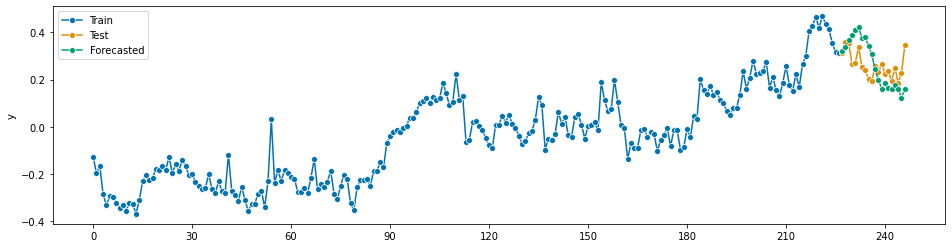

In [32]:
nice_plot(15)

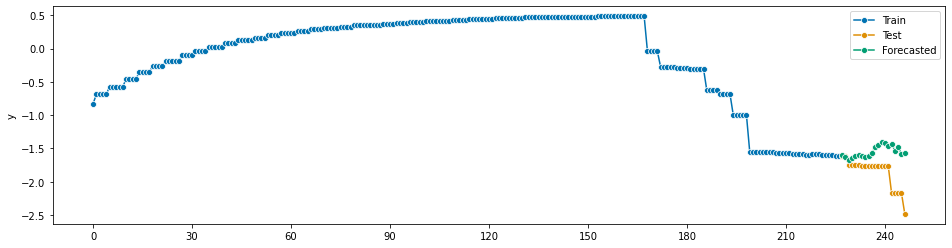

In [33]:
nice_plot(16)

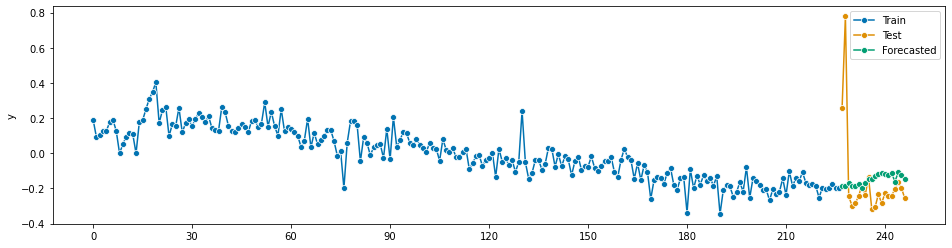

In [34]:
nice_plot(18)

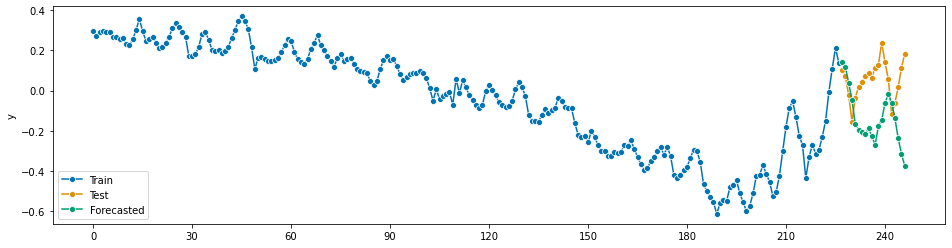

In [35]:
nice_plot(19)

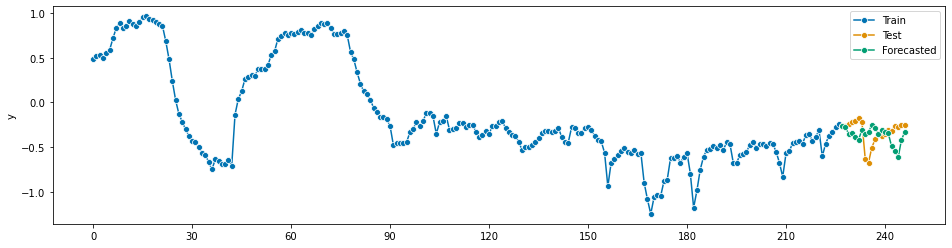

In [36]:
nice_plot(140)

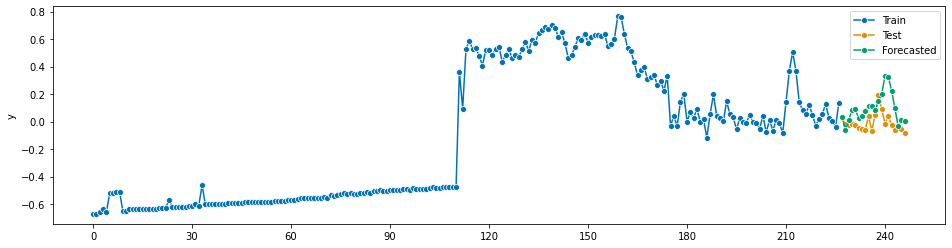

In [37]:
nice_plot(163)

***